In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
backend = provider.get_backend("ibmq_jakarta")


configrc.store_credentials:WARNING:2022-07-09 17:16:55,658: Credentials already present. Set overwrite=True to overwrite.


In [2]:
print(IBMQ.providers())

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='ornl', project='phy147')>]


In [3]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    counter = 0
    temp = [] 
    for key in db:
        temp.append(key)
    print(counter)
    dbfile.close()
    return temp

data=loadData('FGRAFS_controls_N64.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

0
256   64


Job Status: job has successfully run
1 L:  1.1247136844510006
Job Status: job has successfully run
2 L:  0.6666243187311996
Job Status: job has successfully run
[-2.87061229e-08 -6.12878762e-09  1.36839858e+00 -1.53148400e+00]


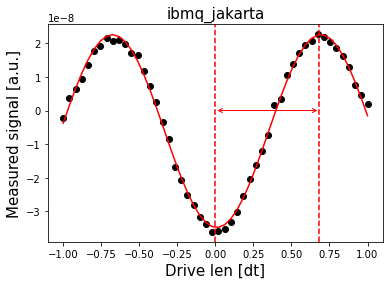

Time taken: 679.8335719108582


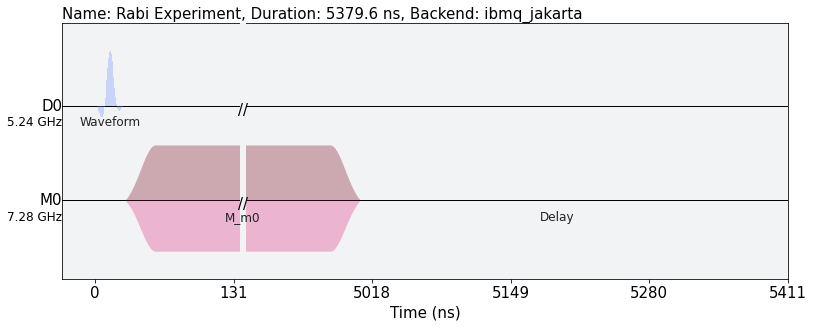

In [4]:
import time

# Generate circuits and run on simulator
t = time.time()
test= [x**2 for x in range(64)]
signal = Su22.Custom_Fgp('low_freq',data,backend)
#print(signal.input)
#print(signal.norm)
print('Time taken:', time.time() - t)
signal.draw()

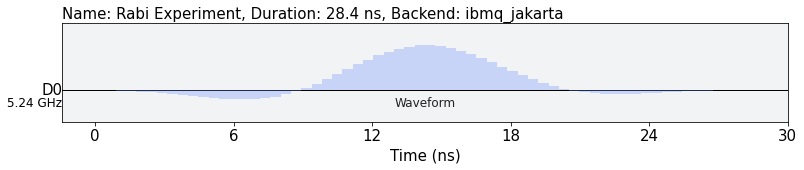

In [5]:
signal.Create_Pulse().draw(backend=backend)

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    error = np.sqrt(np.diag(pcov))
    return fitparams, y_fit,error

drive_amps_2,rabi_values_2 = signal.Cali(50,signal.length)

Job Status: job has successfully run


In [19]:
pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")
signal.pi_p = pi_amp_2

Pi Amplitude = 1.2041455813680055


In [7]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

# Generate circuits and run on simulator
t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
job = qk.execute(qst_bell, backend=backend, shots=5000)
print('Time taken:', time.time() - t)

Time taken: 2.189603328704834


In [8]:
q2 = QuantumRegister(1)
bell = QuantumCircuit(q2)
bell.x(q2[0])
print(bell)

job = qk.execute(bell, backend=Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

t = time.time()
circ = QuantumCircuit(1)
circ = signal.add_as_gate(circ,[0])
#circ.x(0)
qst_bell = state_tomography_circuits(circ,[0])
qst_bell[2].draw('mpl')
print(qst_bell[2])
job = qk.execute(qst_bell, backend=backend, shots=8192)
print('Time taken:', time.time() - t)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)
rho_bell = tomo_bell.fit()

     ┌───┐
q29: ┤ X ├
     └───┘
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
      ┌──────────┐ ░ ┌─┐
   q: ┤ low_freq ├─░─┤M├
      └──────────┘ ░ └╥┘
c1: 1/════════════════╩═
                      0 
Time taken: 1.613356590270996


In [9]:
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity =', F_bell)

Fit Fidelity = 0.9360351562500001


In [108]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer

noise_power = 1e-3
num_noise_trajs = 10

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ):
    x = qk.circuit.ParameterVector('x', length=1)
    temp = circ.copy()
    temp.rz(x[0],0)
    temp.measure(0,0)
    return temp,x

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list
shots=5000
def Spec(circ,start,end,num_center_freqs=100,backend =backend_sim):  
    num_gates=1
    noisy_exp,param_vec = parametrize_circ(circ)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = schwarma_trajectories(a, b, num_gates, num_noise_trajs)
    
        # Build noisy circuit dictionary
        for traj in noise_traj_list:
            bound_params = {param_vec: traj}
            bound_circ = noisy_exp.bind_parameters(bound_params)
            circ_batch.append(bound_circ)

        # Run circuits
    job = qk.execute(circ_batch, backend=backend, optimization_level=0, shots=shots)
    results = job.result()

    # Compile Results
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)-1]:
            zero_counts = results.get_counts(circ).get('1',0)
            prob += zero_counts/shots
        prob = prob/num_noise_trajs
        all_probs[center_idxs[counter], :] = centers[counter], prob
        counter+=1
        prob=0
    return all_probs, circ_batch

In [113]:
num_noise_trajs_2 = 30
def Spec_2(circ,start,end,num_center_freqs=100,backend =backend_sim):  
    num_gates=1
    noisy_exp,param_vec = parametrize_circ(circ)
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = schwarma_trajectories(a, b, num_gates, num_noise_trajs_2)
        # Build noisy circuit dictionary
        circ_batch = []
        for traj in noise_traj_list:
            bound_circ = noisy_exp.bind_parameters({param_vec: traj})
            circ_batch.append(bound_circ)

        # Run circuits
        job = qk.execute(circ_batch, backend=backend, optimization_level=0, shots=shots)
        results = job.result()

        # Compile Results
        prob = 0
        for circ in circ_batch:
            zero_counts = results.get_counts(circ).get('1',0)
            prob += zero_counts/shots
        prob = prob/num_noise_trajs_2

        all_probs[center_idx, :] = center, prob
    return all_probs, circ_batch

In [81]:
armonk_model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator(system_model=armonk_model)

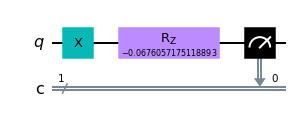

In [114]:
circ = QuantumCircuit(1,1)
circ.x(0)
#circ = signal.add_as_gate(circ,[0])
all_p, batch_circ = Spec_2(circ,0.02,0.98,100,backend = signal.backend)
batch_circ[2].draw('mpl')

Text(0.5, 0, 'Center Frequency')

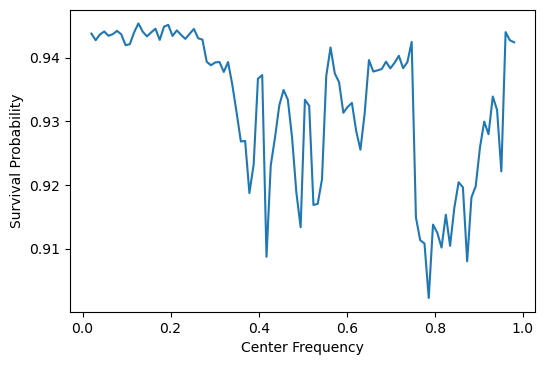

In [117]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

Time taken: 9858.253046274185


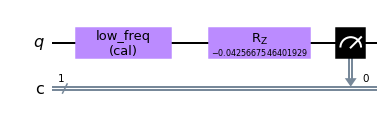

In [122]:
circ = QuantumCircuit(1,1)
#circ.x(0)
circ = signal.add_as_gate(circ,[0])
t = time.time()
all_p_2, batch_circ_2 = Spec_2(circ,0.02,0.98,100,backend=signal.backend)
print('Time taken:', time.time() - t)
batch_circ_2[2].draw('mpl')

Text(0.5, 0, 'Center Frequency')

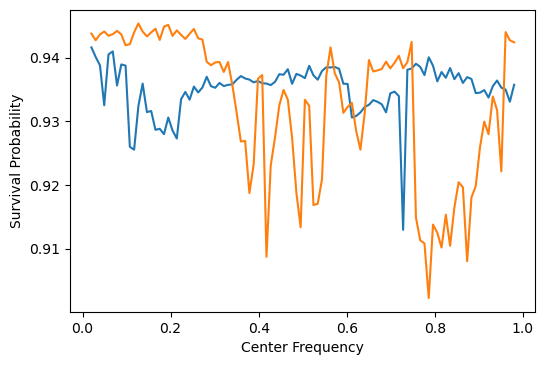

In [124]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p_2[:,0], 1-all_p_2[:,1])
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [130]:
with open('Xgate.p', 'wb') as handle:
    pickle.dump(all_p, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Filter.p', 'wb') as handle:
    pickle.dump(all_p_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Job Status: job has successfully run
1 L:  0.7677296106951823
Job Status: job has successfully run
[-1.29793801e-09  5.55605888e-11  1.06468650e+00  1.47483976e+00]


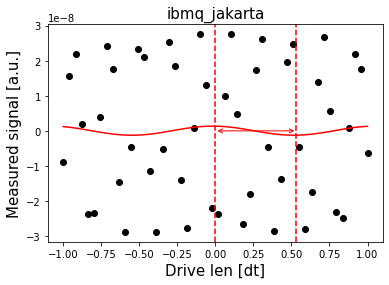

In [126]:
signal_data= [1 for x in range(160)]
signal2 =  Su22.Custom_Fgp('high_freq',signal_data,backend)

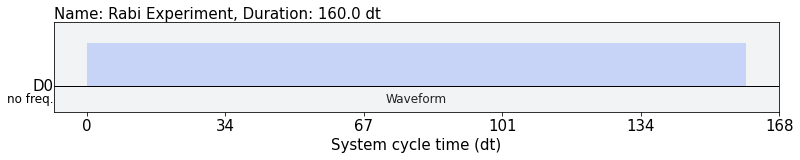

In [128]:
signal2.Create_Pulse().draw()

In [ ]:
circ_2 = QuantumCircuit(1,1)
circ_2 = signal2.add_as_gate(circ_2,[0])
t = time.time()
all_p_3, batch_circ_3 = Spec_2(circ_2,0.02,0.98,100,backend=signal.backend)
print('Time taken:', time.time() - t)
batch_circ_3[2].draw('mpl')

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p_3[:,0], 1-all_p_3[:,1])
ax.plot(all_p_2[:,0], 1-all_p_2[:,1])
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [111]:
job= backend.retrieve_job('62ca2ae97f0655a83b8a40ed')
results = job.result()
prob = 0
counter = 0
num_center_freqs=30
center_idxs=[]
centers=[]
all_probs = np.zeros([num_center_freqs, 2])
circ_batch = np.zeros(300)
for center_idx, center in enumerate(np.linspace(0.02, 0.98,30, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
cc=0
for i in range(int(len(circ_batch)/num_noise_trajs)):
    for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)-1]:
        zero_counts = results.get_counts(cc).get('1')
        prob += zero_counts/shots
        cc+=1
    prob = prob/num_noise_trajs
    all_probs[center_idxs[counter], :] = centers[counter], prob
    counter+=1
    prob=0

Text(0.5, 0, 'Center Frequency')

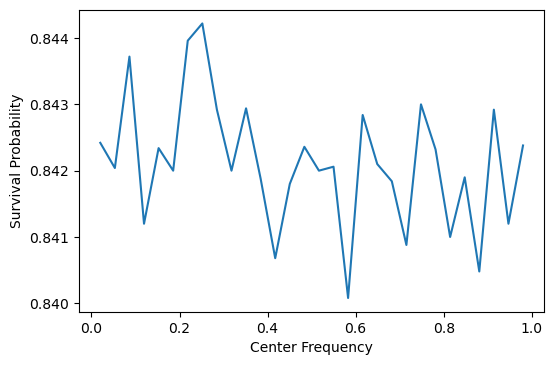

In [112]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [100]:
print(all_probs)

[[0.02       0.8413    ]
 [0.05310345 0.8432    ]
 [0.0862069  0.8491    ]
 [0.11931034 0.8479    ]
 [0.15241379 0.8407    ]
 [0.18551724 0.8459    ]
 [0.21862069 0.8471    ]
 [0.25172414 0.8464    ]
 [0.28482759 0.8523    ]
 [0.31793103 0.8472    ]
 [0.35103448 0.8456    ]
 [0.38413793 0.8459    ]
 [0.41724138 0.8474    ]
 [0.45034483 0.8507    ]
 [0.48344828 0.8475    ]
 [0.51655172 0.8436    ]
 [0.54965517 0.8468    ]
 [0.58275862 0.846     ]
 [0.61586207 0.8483    ]
 [0.64896552 0.8408    ]
 [0.68206897 0.8489    ]
 [0.71517241 0.8459    ]
 [0.74827586 0.8496    ]
 [0.78137931 0.8442    ]
 [0.81448276 0.8452    ]
 [0.84758621 0.8466    ]
 [0.88068966 0.8445    ]
 [0.9137931  0.844     ]
 [0.94689655 0.8476    ]
 [0.98       0.8471    ]]
